In [8]:
from joblib import dump

from dask.distributed import Client
from dea_tools.classification import predict_xr
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

from dep_coastlines.MosaicLoader import DeluxeMosaicLoader
from dep_tools.namers import DepItemPath
from dep_tools.azure import get_container_client

from dep_coastlines.mask_model import prep_training_data

In [9]:
(
    training_data
        .loc[:,['code', 'red', 'blue', 'green', 'nir08', 'swir16', 'swir22', 'mndwi', 'ndwi']]
        .groupby('code')
        .median()
)

,red,blue,green,nir08,swir16,swir22,mndwi,ndwi
code,,,,,,,,
bare_terrain,436.0,270.0,420.0,1188.0,1299.0,722.0,-0.504065,-0.538040
clean_water,24.5,357.5,359.5,17.5,160.5,151.0,0.429611,0.912763
cloud,2001.5,2140.5,2052.5,2021.0,1612.5,1343.0,0.170435,0.015860
coast,789.5,562.0,811.0,1374.5,617.0,372.0,0.190971,-0.160166
land,334.0,244.5,596.5,3909.5,1517.5,654.5,-0.423067,-0.739503
noise,591.5,699.5,789.0,2484.5,1362.0,691.5,0.031722,-0.090403
noisy_water,-3.0,135.0,66.5,67.0,220.0,209.5,-0.529212,-0.029150
surf,1654.5,1814.5,1939.0,1532.5,475.5,263.5,0.622780,0.162264


In [18]:

codes = pd.DataFrame.from_records(
   [
        ("land",         1,1,0,1, "#064a00"),
        ('clean_water',  9,2,0,2, "#ff0000"),
        ('water',        2,3,0,2, "#ff0000"),
        ('deep_water',   3,3,0,2, "#ff0000"),
        ("noisy_water",  8,7,0,2, "#00ffff"),
        ("surf",         4,4,0,4, "#ddfeff"),
        ("coast",        5,5,0,5, "#ffe48b"),
        ("cloud",        6,6,1,6, "#a9a9a9"),
        ("noise",        7,6,1,6, "#e16be1"),
        ('bare_terrain',10,8,0,8, "#0000ff"),
    ],
    columns=["code", "intcode", "simplintcode", "unified_water", "cloud", "color"],
)

[1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [13]:
removes = ['shift']#, 'deep_ocean', 'water']
training_data = pd.read_csv("../data/training_data_with_features_9Feb.csv").query('code not in @removes')

training_data = training_data.join(codes.set_index("code"), on="code")
training_columns = [
        "blue",
        "blue_mad",
       "count",
        "green",
        "green_mad",
        "nir08",
       "nir08_mad",
      "nir08_stdev",
        "red",
        "red_mad",
        "swir16",
        "swir16_mad",
        "swir22",
        "swir22_mad",
        "blue_dev",
     #   "count_dev",
        "green_dev",
        "red_dev",
        "nir08_dev",
        "swir16_dev",
        "swir22_dev",
       "blue_all",
    #   "count_all",
       "green_all",
        "nir08_all",
        "red_all",
       "swir16_all",
     "swir22_all",
     "mndwi",
     "ndwi",
     "mndwi_all",
     "ndwi_all"
]
training_data = training_data.dropna(subset=training_columns)
from sklearn import preprocessing
X = training_data.loc[:, training_columns].to_numpy()
response_column = 'unified_water'
y = training_data[response_column].to_numpy()
m = RandomForestClassifier()
cv = cross_val_score(m, X, y, cv=10)
cxp = cross_val_predict(m, X, y, cv=10)
pd.crosstab(y, cxp)


/home/jesse/Projects/D4D/dep-coastlines/venv/lib/python3.10/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y contains NaN.

In [117]:
cv.mean()

0.9202668845315903

In [115]:
full_model = m.fit(X, y)

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(m, prefit=True)
from itertools import compress
shrunk_columns = list(compress(training_columns,model.get_support()))
X_new = model.transform(X)
cv_shrunk = cross_val_score(m, X_new, y, cv=10)
cv_shrunk.mean()
shrunk_columns


['blue',
 'green',
 'nir08',
 'red',
 'swir22_dev',
 'blue_all',
 'green_all',
 'nir08_all',
 'red_all',
 'swir16_all',
 'mndwi',
 'mndwi_all']

In [51]:
X_new.shape

(1351, 13)

In [118]:
#shrunk_full_model = m.fit(X_new, y)
full_model = m.fit(X, y)

output = dict(
    model = full_model,
    training_data = training_data,
    predictor_columns = training_columns,
    response_column=response_column,
    codes=codes,    
)
dump(output, '../data/model_9Feb_2.joblib')



['../data/model_9Feb_2.joblib']

In [54]:
anitempath = DepItemPath(
        sensor="ls",
        dataset_id="coastlines/mosaics-corrected",
        version="0.6.0",
        time="2020",
        zero_pad_numbers=True,
)
loader = DeluxeMosaicLoader(
    itempath=anitempath,
)

df = pd.DataFrame([(53,47)])
df.index = [(53,47)]
ds = loader.load(df)
ds

<xarray.Dataset>
Dimensions:          (x: 2009, y: 658)
Coordinates:
    band             int64 1
  * x                (x) float64 5.01e+05 5.011e+05 ... 5.612e+05 5.613e+05
  * y                (y) float64 7.971e+05 7.971e+05 ... 7.774e+05 7.774e+05
    spatial_ref      int64 0
Data variables: (12/48)
    blue             (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    blue_mad         (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    count            (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    green            (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    green_mad        (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    nir08            (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    ...               ...
    swir16_all       (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    swir16_mad_all   (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    swir22_all       (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    swir22_mad_all   (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    mndwi_all        (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>
    ndwi_all         (y, x) float32 dask.array<chunksize=(658, 2009), meta=np.ndarray>

In [55]:
with Client():
    output = predict_xr(shrunk_full_model, ds[shrunk_columns], clean=True).Predictions
#output = output.where(~np.isnan(ds.red)).rio.write_crs(ds.red.rio.crs)
#del output.attrs['grid_mapping']
#output.rio.to_raster('scratch_9923_with_all.tif', overwrite=True)
output.odc.explore()

predicting...


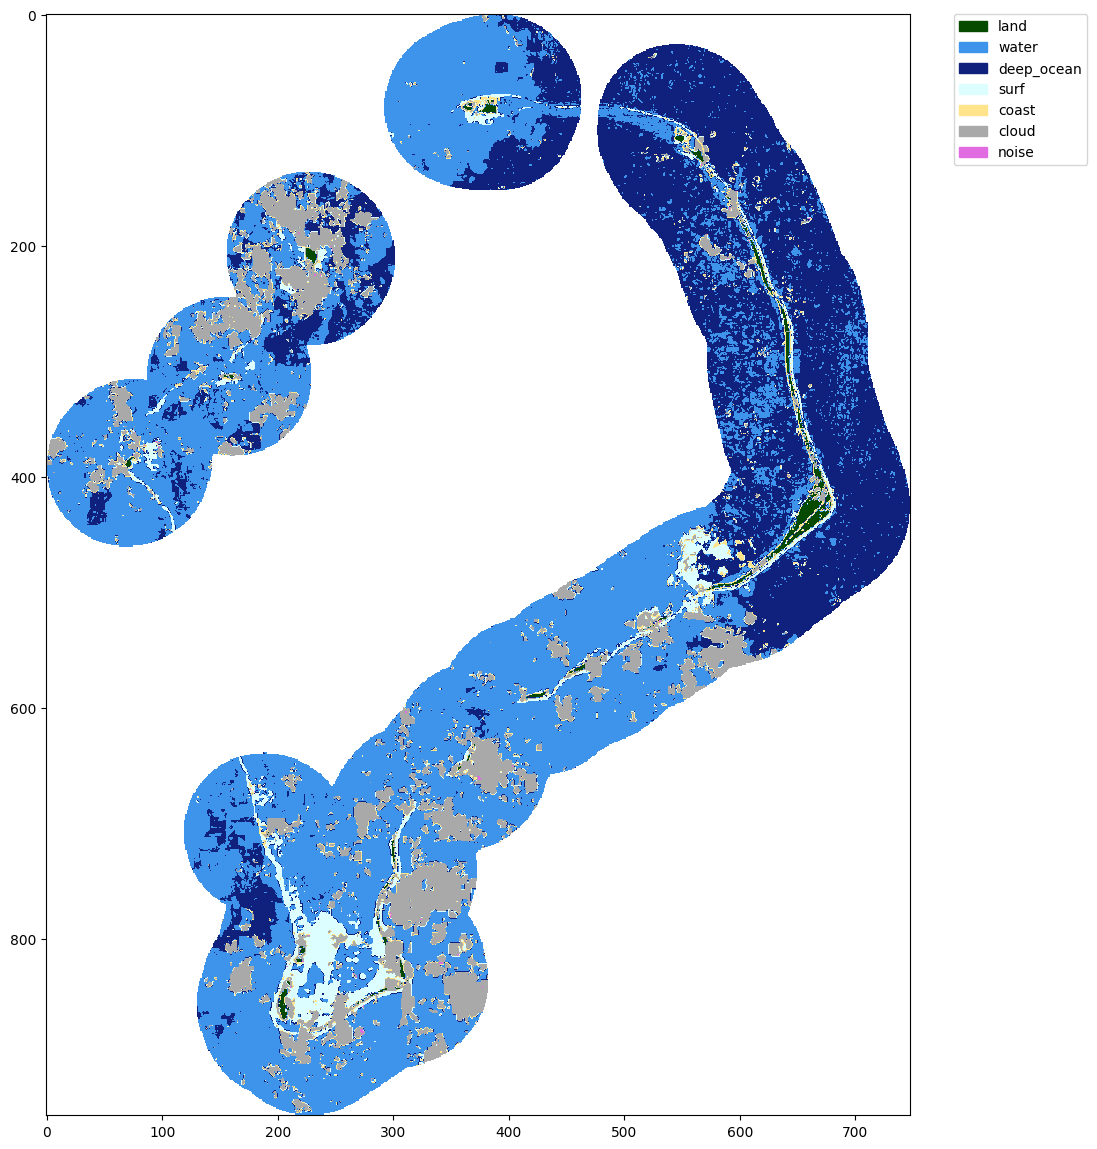

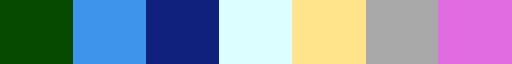

In [120]:
# Plot output as image
%matplotlib inline

#codes = codes.set_index('intcode')
colormap = ['#ffffff'] * (max(codes.index))
for i in codes.index:
  colormap[i-1] = codes.loc[i,'color']

legend_patches = [ mpatches.Patch(color=codes.loc[i].color, label=codes.loc[i].code) 
                  for i in codes.index 
                   if i in np.unique(output)
                 ]
plt.figure(figsize=(19.2, 14.3))
cmap = ListedColormap(colormap)
plot = plt.imshow(output, cmap=cmap)
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(False)
plt.show()